# Stellargraph example: Graph Attention Network (GAT) on the CORA citation dataset

Import NetworkX and stellar:

In [ ]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.expanduser("~/data/cora")

Load the graph from edgelist

In [3]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["source", "target"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [8]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=140, test_size=None, stratify=node_data['subject'])
val_data, test_data = model_selection.train_test_split(test_data, train_size=500, test_size=None, stratify=test_data['subject'])

Note using stratified sampling gives the following counts:

In [9]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Case_Based': 16,
         'Probabilistic_Methods': 22,
         'Neural_Networks': 42,
         'Reinforcement_Learning': 11,
         'Theory': 18,
         'Genetic_Algorithms': 22,
         'Rule_Learning': 9})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [11]:
node_features = node_data[feature_names]

## Creating the GAT model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [12]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [14]:
generator = FullBatchNodeGenerator(G)

For training we map only the training nodes returned from our splitter and the target values.

In [15]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GAT layers with 8-dimensional hidden node features at each layer.
 * `attn_heads` is the number of attention heads in all but the last GAT layer in the model
 * `activations` is a list of activations applied to each layer's output
 * Arguments such as `bias`, `in_dropout`, `attn_dropout` are internal parameters of the model, execute `?GAT` for details. 

To follow the GAT model architecture used for Cora dataset in the original paper [Graph Attention Networks. P. Velickovic et al. ICLR 2018 https://arxiv.org/abs/1803.07294], let's build a 2-layer GAT model, with the 2nd layer being the classifier that predicts paper subject: it thus should have the output size of `train_targets.shape[1]` (7 subjects) and a softmax activation.

In [16]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    attn_heads=8,
    generator=generator,
    bias=True,
    in_dropout=0.5,
    attn_dropout=0.5,
    activations=["elu","softmax"],
    normalize=None,
)

In [17]:
# Expose the input and output tensors of the GAT model for node prediction, via GAT.node_model() method:
x_inp, predictions = gat.node_model()

Note that `x_inp` is a list of two input tensors, one for node features, the other for graph adjacency matrix

In [18]:
x_inp

[<tf.Tensor 'input_1:0' shape=(?, 1433) dtype=float32>,

In [19]:
predictions.shape

TensorShape([Dimension(None), Dimension(7)])

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [20]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    weighted_metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [21]:
val_gen = generator.flow(val_data.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(monitor="val_weighted_acc", patience=50)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5",
    monitor="val_weighted_acc",
    save_best_only=True,
    save_weights_only=True,
)

Train the model

In [23]:
history = model.fit_generator(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/200
 - 4s - loss: 2.0515 - weighted_acc: 0.1643 - val_loss: 1.8610 - val_weighted_acc: 0.3220
Epoch 2/200
 - 2s - loss: 1.9633 - weighted_acc: 0.1929 - val_loss: 1.7865 - val_weighted_acc: 0.3320
Epoch 3/200
 - 2s - loss: 1.8128 - weighted_acc: 0.3357 - val_loss: 1.7214 - val_weighted_acc: 0.3480
Epoch 4/200
 - 2s - loss: 1.8340 - weighted_acc: 0.2357 - val_loss: 1.6642 - val_weighted_acc: 0.3960
Epoch 5/200
 - 2s - loss: 1.7082 - weighted_acc: 0.3286 - val_loss: 1.6094 - val_weighted_acc: 0.4500
Epoch 6/200
 - 2s - loss: 1.6330 - weighted_acc: 0.4500 - val_loss: 1.5571 - val_weighted_acc: 0.4820
Epoch 7/200
 - 2s - loss: 1.5967 - weighted_acc: 0.4357 - val_loss: 1.5089 - val_weighted_acc: 0.5200
Epoch 8/200
 - 2s - loss: 1.4550 - weighted_acc: 0.4929 - val_loss: 1.4629 - val_weighted_acc: 0.5620
Epoch 9/200
 - 2s - loss: 1.5104 - weighted_acc: 0.4929 - val_loss: 1.4191 - val_weighted_acc: 0.5880
Epoch 10/200
 - 2s - loss: 1.5640 - weighted_acc: 0.4500 - val_loss: 1.3776 - val_

Epoch 81/200
 - 2s - loss: 0.7768 - weighted_acc: 0.7000 - val_loss: 0.6507 - val_weighted_acc: 0.8020
Epoch 82/200
 - 2s - loss: 0.8150 - weighted_acc: 0.7429 - val_loss: 0.6487 - val_weighted_acc: 0.8040
Epoch 83/200
 - 2s - loss: 0.7470 - weighted_acc: 0.7571 - val_loss: 0.6468 - val_weighted_acc: 0.8040
Epoch 84/200
 - 2s - loss: 0.7559 - weighted_acc: 0.7500 - val_loss: 0.6447 - val_weighted_acc: 0.8060
Epoch 85/200
 - 2s - loss: 0.7774 - weighted_acc: 0.7429 - val_loss: 0.6424 - val_weighted_acc: 0.8120
Epoch 86/200
 - 2s - loss: 0.6494 - weighted_acc: 0.7929 - val_loss: 0.6406 - val_weighted_acc: 0.8080
Epoch 87/200
 - 2s - loss: 0.7666 - weighted_acc: 0.7286 - val_loss: 0.6395 - val_weighted_acc: 0.8120
Epoch 88/200
 - 2s - loss: 0.6762 - weighted_acc: 0.8000 - val_loss: 0.6382 - val_weighted_acc: 0.8160
Epoch 89/200
 - 2s - loss: 0.7939 - weighted_acc: 0.7000 - val_loss: 0.6373 - val_weighted_acc: 0.8160
Epoch 90/200
 - 2s - loss: 0.8664 - weighted_acc: 0.7143 - val_loss: 0.63

Epoch 160/200
 - 2s - loss: 0.6589 - weighted_acc: 0.7571 - val_loss: 0.5975 - val_weighted_acc: 0.8180
Epoch 161/200
 - 2s - loss: 0.7624 - weighted_acc: 0.7286 - val_loss: 0.5981 - val_weighted_acc: 0.8200


Plot the training history:

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

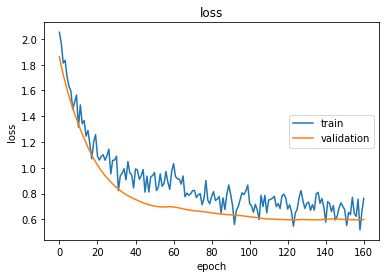

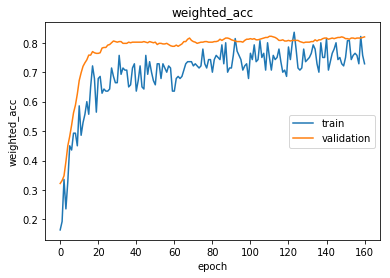

In [25]:
plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [26]:
model.load_weights("logs/best_model.h5")

Evaluate the best model on the test set

In [27]:
test_gen = generator.flow(test_data.index, test_targets)

In [28]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.6155
	weighted_acc: 0.8235


### Making predictions with the model

Now let's get the predictions for all nodes:

Note that the `predict` or `predict_generator` function now operates differently to the `GraphSAGE` or `HinSAGE` models
in that if you give it a set of nodes, it will still return predictions for **all** nodes in the graph, and in a fixed order defined by the order of nodes in `X` and `A` (which is defined by the order of `G.nodes()`).

In [29]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [30]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few (note that generator orders nodes according to the order in G.nodes(), so the predictions are ordered like that as well. We thus need to index results as `G.nodes()`

In [31]:
results = pd.DataFrame(node_predictions, index=G.nodes()).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(20)

,Predicted,True
35,subject=Genetic_Algorithms,Genetic_Algorithms
40,subject=Genetic_Algorithms,Genetic_Algorithms
114,subject=Reinforcement_Learning,Reinforcement_Learning
117,subject=Reinforcement_Learning,Reinforcement_Learning
128,subject=Reinforcement_Learning,Reinforcement_Learning
130,subject=Reinforcement_Learning,Reinforcement_Learning
164,subject=Theory,Theory
288,subject=Reinforcement_Learning,Reinforcement_Learning
424,subject=Neural_Networks,Rule_Learning
434,subject=Neural_Networks,Reinforcement_Learning


## Node embeddings
Evaluate node embeddings as activations of the output of the 1st GraphAttention layer in GAT layer stack (the one before the top classification layer predicting paper subjects), and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

The GAT embeddings are the output of the 1st GraphAttention layer in the GAT layers stack, namely the 3rd layer in model.layers. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [32]:
emb_layer = model.layers[3]
print("Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape))

Embedding layer: graph_attention_1, output shape (None, 64)


In [33]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

In [34]:
emb = embedding_model.predict_generator(all_gen)
emb.shape

(2708, 64)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their true subject label

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

Note that the generator orders nodes according to the order in G.nodes(), so we need to re-index node_data

In [36]:
X = emb
y = np.argmax(target_encoding.transform(node_data.reindex(G.nodes())[["subject"]].to_dict('records')), axis=1)

In [37]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

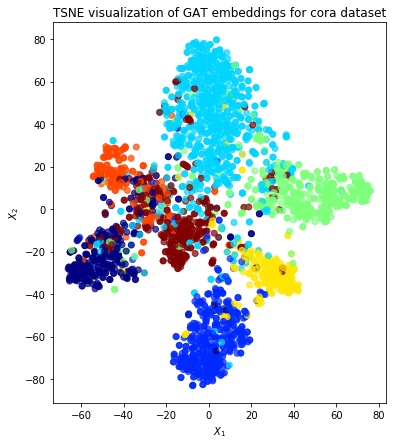

In [38]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GAT embeddings for cora dataset'.format(transform.__name__))
plt.show()